<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Sig-kernel-gradients" data-toc-modified-id="Sig-kernel-gradients-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Sig kernel gradients</a></span></li><li><span><a href="#Sig-Loss-gradients" data-toc-modified-id="Sig-Loss-gradients-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Sig Loss gradients</a></span></li><li><span><a href="#Gradients-with-var-par-and-direct-solver" data-toc-modified-id="Gradients-with-var-par-and-direct-solver-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gradients with var-par and direct solver</a></span></li></ul></div>

In [1]:
!git clone 'https://github.com/crispitagorico/Signature-Kernel.git'

Cloning into 'Signature-Kernel'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 574 (delta 0), reused 1 (delta 0), pack-reused 570
Receiving objects: 100% (574/574), 21.91 MiB | 33.94 MiB/s, done.
Resolving deltas: 100% (302/302), done.


In [2]:
%cd /content/Signature-Kernel/src/ 

/content/Signature-Kernel/src


In [3]:
!python setup.py build_ext --inplace

Compiling sigKer_fast.pyx because it changed.
[1/1] Cythonizing sigKer_fast.pyx
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/Signature-Kernel/src/sigKer_fast.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
running build_ext
building 'sigKer_fast' extension
creating build/temp.linux-x86_64-3.6
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -c sigKer_fast.c -o build/temp.linux-x86_64-3.6/sigKer_fast.o
creating build/lib.linux-x86_64-3.6
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -Wl,-z,relro -Wl,-Bsymbolic-functions -Wl,-z,relro -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 build/temp.linux-x8

In [4]:
import sys
sys.path.append('../src')
sys.path.append('../utils')

import torch
import time
import numpy as np
# from tools import brownian, Lorenz
# from scipy.integrate import odeint

from sigKer_torch import SigKernel, SigKernelCuda
from sigLoss import SigLoss

# from sigKerHom_torch import SigLossHom

import matplotlib.pyplot as plt
import pandas as pd

# Sig kernel gradients

In [5]:
N = 50
l = 10
d = 3

X = np.random.randn(N,l,d).cumsum(axis=1)
Y = np.random.randn(N,l,d).cumsum(axis=1)

X /= np.max(X)
Y /= np.max(Y)

X = torch.tensor(X, dtype=torch.float64).cuda()
Y = torch.tensor(Y, dtype=torch.float64).cuda()

X.requires_grad = True

In [8]:
t = time.time()
ker_naive = SigKernel.apply(X,Y)
print('time:', np.round(time.time()-t,3), 's')
print(ker_naive)

time: 0.005 s
tensor([1.5625, 0.7842, 0.7440, 0.3088, 0.6672, 0.9485, 0.7803, 1.2798, 1.6235,
        1.1841, 0.3501, 0.9905, 1.0895, 1.0568, 1.0046, 1.4401, 0.7334, 0.9272,
        0.7965, 1.0585, 1.0134, 1.1822, 1.0378, 1.0651, 0.9582, 0.5103, 1.0233,
        0.5589, 1.0153, 1.6803, 0.9904, 0.8789, 1.2016, 1.1085, 1.1903, 1.2502,
        0.8274, 1.3536, 0.8517, 1.1068, 0.5379, 1.0062, 1.7685, 1.0323, 0.6309,
        0.9221, 1.0174, 1.0238, 0.5868, 1.7397], device='cuda:0',
       dtype=torch.float64, grad_fn=<SigKernelBackward>)


In [9]:
t = time.time()
ker = SigKernelCuda.apply(X,Y)
print('time:', np.round(time.time()-t,3), 's')
print(ker)

time: 0.002 s
tensor([1.5625, 0.7842, 0.7440, 0.3088, 0.6672, 0.9485, 0.7803, 1.2798, 1.6235,
        1.1841, 0.3501, 0.9905, 1.0895, 1.0568, 1.0046, 1.4401, 0.7334, 0.9272,
        0.7965, 1.0585, 1.0134, 1.1822, 1.0378, 1.0651, 0.9582, 0.5103, 1.0233,
        0.5589, 1.0153, 1.6803, 0.9904, 0.8789, 1.2016, 1.1085, 1.1903, 1.2502,
        0.8274, 1.3536, 0.8517, 1.1068, 0.5379, 1.0062, 1.7685, 1.0323, 0.6309,
        0.9221, 1.0174, 1.0238, 0.5868, 1.7397], device='cuda:0',
       dtype=torch.float64, grad_fn=<SigKernelCudaBackward>)


# Sig Loss gradients

In [10]:
N = 2
l = 3
d = 2

X = np.random.randn(N,l,d).cumsum(axis=1)
Y = np.random.randn(N,l,d).cumsum(axis=1)

X /= np.max(X)
Y /= np.max(Y)

X = torch.tensor(X, dtype=torch.float64).cuda()
Y = torch.tensor(Y, dtype=torch.float64).cuda()
X_ = X.clone().cpu()
Y_ = Y.clone().cpu()

X.requires_grad = True
X_.requires_grad = True

In [11]:
t = time.time()
l = SigLoss(n_chunks=1).forward(X_,Y_)
print('time:', np.round(time.time()-t,3), 's')
print(l)

time: 0.024 s
tensor(1.7807, dtype=torch.float64, grad_fn=<MeanBackward0>)


In [12]:
t = time.time()
l_cuda = SigLoss(n_chunks=1).forward(X,Y)
print('time:', np.round(time.time()-t,3), 's')
print(l_cuda)

time: 0.009 s
tensor(1.7807, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)


In [13]:
t = time.time()
l.backward()
print('time:', np.round(time.time()-t,3), 's')
print(X_.grad)

time: 0.004 s
tensor([[[ 0.1054,  0.3559],
         [-0.0760, -0.0189],
         [-0.0295, -0.3370]],

        [[-1.6248, -1.3119],
         [-0.1655, -0.5785],
         [ 1.7903,  1.8904]]], dtype=torch.float64)


In [14]:
# X.grad.data.zero_()
t = time.time()
l_cuda.backward()
print('time:', np.round(time.time()-t,3), 's')
print(X.grad)

NameError: ignored

# Gradients with var-par and direct solver

In [ ]:
n=0

A, m, d = 1, 10, 3
# X = torch.tensor(Lorenz(A, m), dtype=torch.float64)
# Y = torch.tensor(Lorenz(A, m), dtype=torch.float64)
X = torch.tensor(0.3*np.cumsum(np.random.randn(A,m,d),axis=1),dtype=torch.float64)
Y = torch.tensor(0.3*np.cumsum(np.random.randn(A,m,d),axis=1),dtype=torch.float64)
# Y = X.clone()
X_ = X.clone()

X.requires_grad = True
X_.requires_grad = True

In [ ]:
grad_direct_old = [] 
direct_old = [] 
for o in range(8):
    l_direct = SigLoss(n=o,n_chunks=1,solver=0,method='new').forward(X,Y)
    direct_old.append(l_direct.detach().numpy().copy())
    l_direct.backward()
    grad_direct_old.append(X.grad.detach().numpy().copy())
    X.grad.data.zero_()

grad_direct_explicit = [] 
direct_explicit = [] 
for o in range(8):
    l_direct = SigLoss(n=o,n_chunks=1,solver=1,method='new').forward(X,Y)
    direct_explicit.append(l_direct.detach().numpy().copy())
    l_direct.backward()
    grad_direct_explicit.append(X.grad.detach().numpy().copy())
    X.grad.data.zero_()

In [ ]:
grad_varpar_old = [] 
for o in range(8):
    l_old = SigLoss(n=o,n_chunks=1,solver=0).forward(X,Y)
    l_old.backward()
    grad_varpar_old.append(X.grad.detach().numpy().copy())
    X.grad.data.zero_()
    
grad_varpar_explicit = [] 
for o in range(8):
    l_old = SigLoss(n=o,n_chunks=1,solver=1).forward(X,Y)
    l_old.backward()
    grad_varpar_explicit.append(X.grad.detach().numpy().copy())
    X.grad.data.zero_()

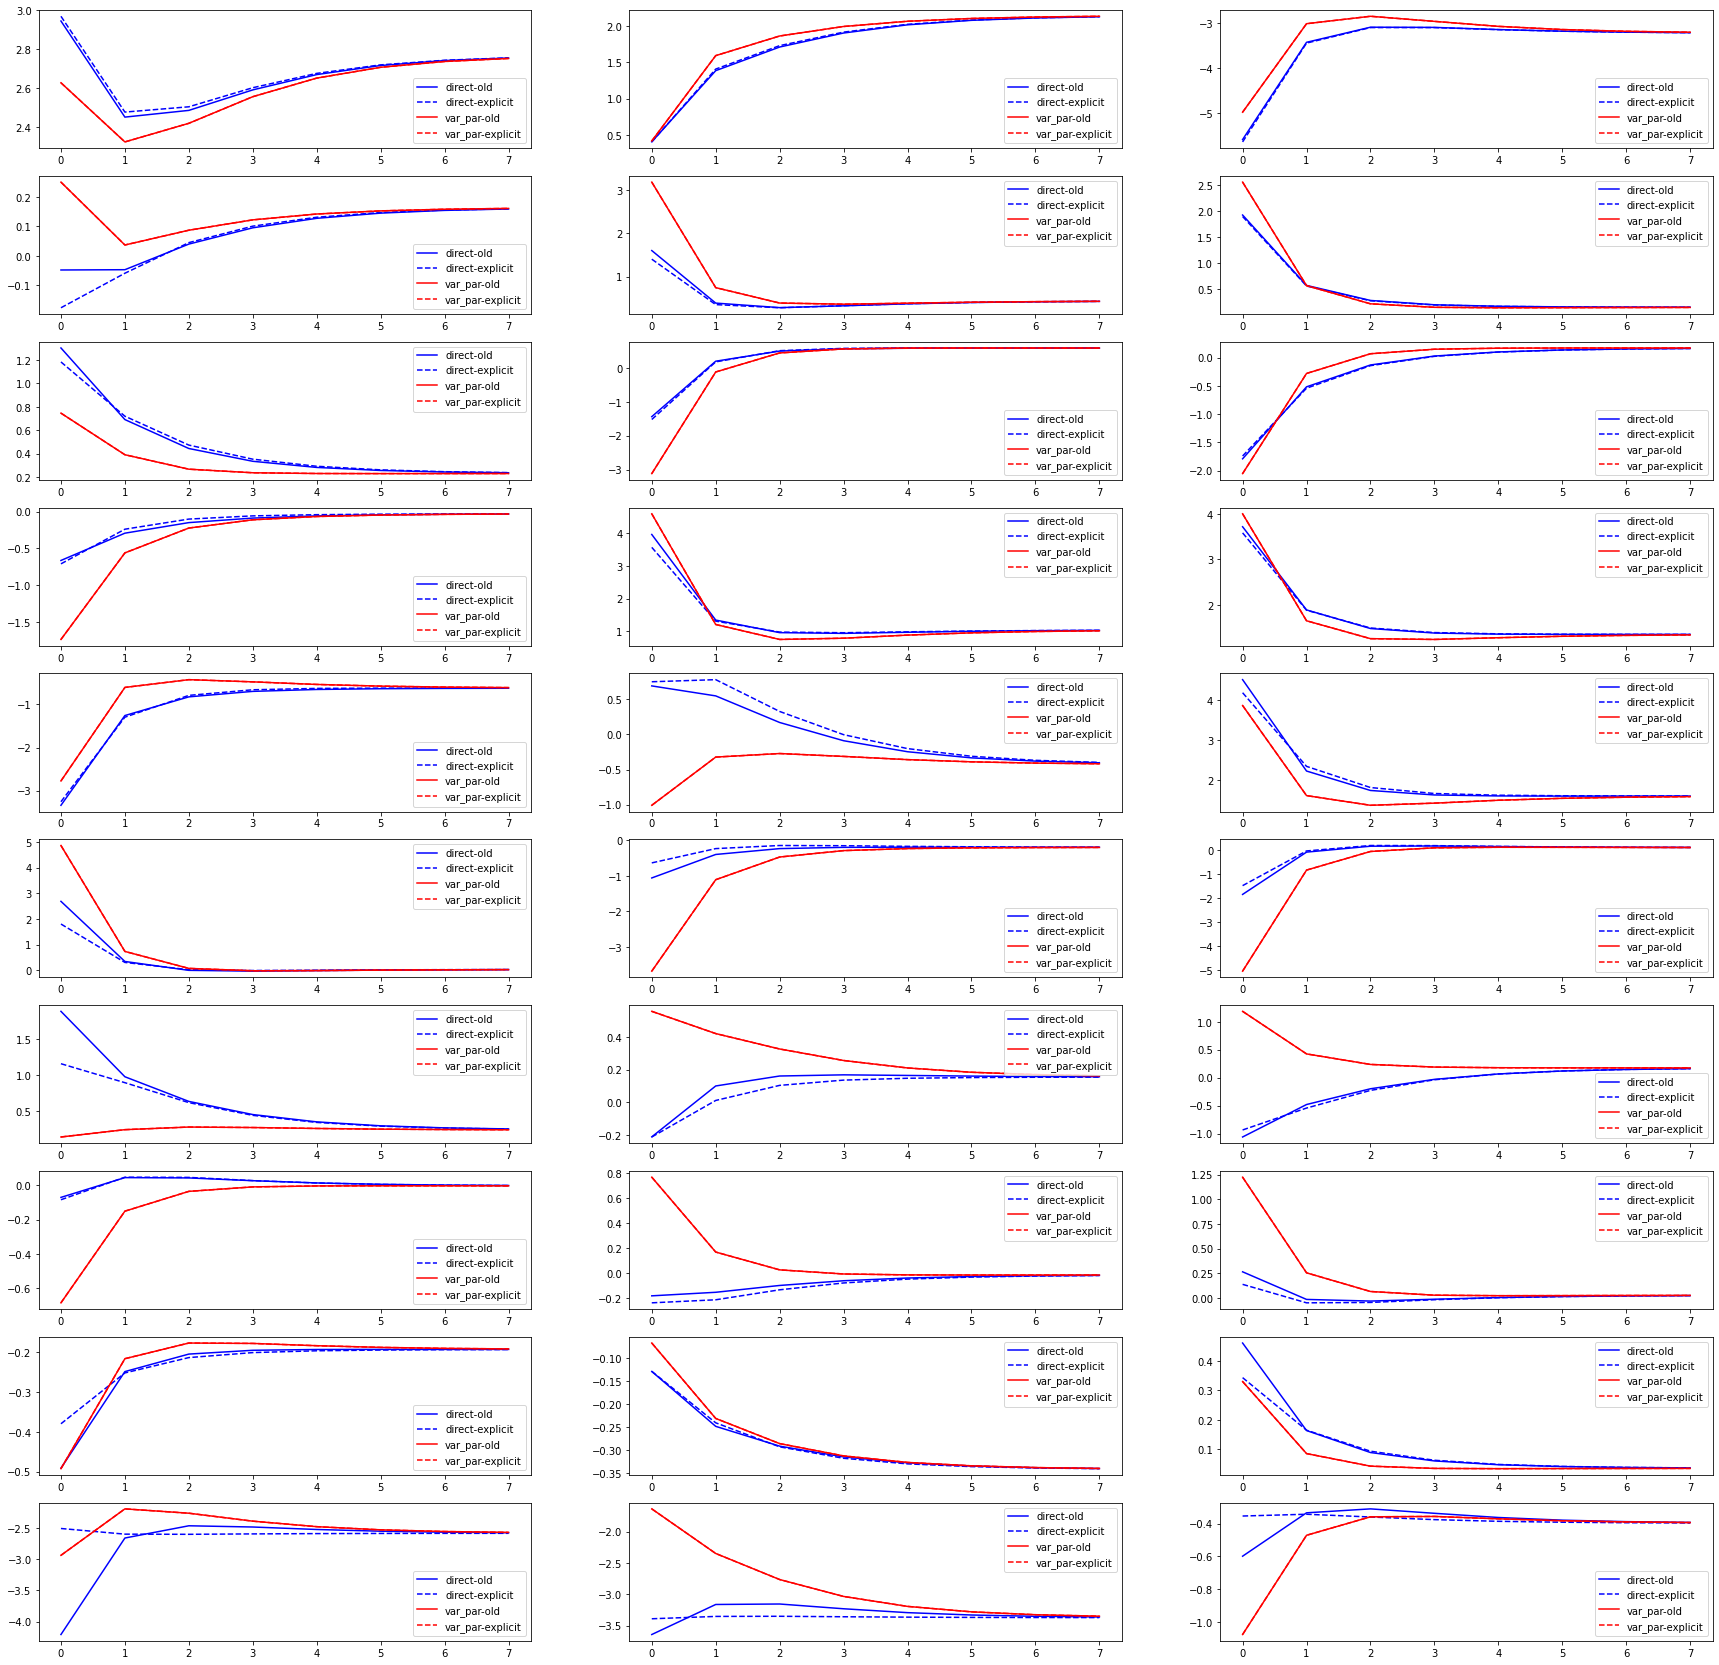

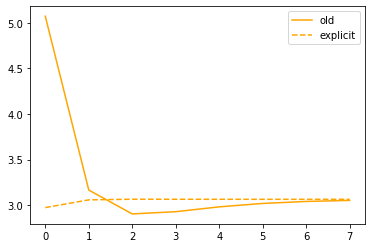

In [ ]:
fig, ax = plt.subplots(m,d,figsize=(3*m,10*d))


for i in range(m):
    for j in range(d):
        ax[i][j].plot([e[0][i][j] for e in grad_direct_old],label='direct-old',color='blue')
        ax[i][j].plot([e[0][i][j] for e in grad_direct_explicit],label='direct-explicit',color='blue',ls='--')
        ax[i][j].plot([e[0][i][j] for e in grad_varpar_old],label='var_par-old',color='red')
        ax[i][j].plot([e[0][i][j] for e in grad_varpar_explicit],label='var_par-explicit',color='red',ls='--')
        ax[i][j].legend()
plt.show()

plt.plot([e for e in direct_old],label='old',color='orange')
plt.plot([e for e in direct_explicit],label='explicit',color='orange',ls='--')
plt.legend()
plt.show()

In [ ]:

gradients = [[[] for i in range(d)] for j in range(m)]
for i in range(m):
    for j in range(d):
        gradients[i][j]={'direct_old':[e[0][i][j] for e in grad_direct_old], 'direct_explicit':[e[0][i][j] for e in grad_direct_old], 'varpar_old':[e[0][i][j] for e in grad_varpar_old],'varpar_explicit':[e[0][i][j] for e in grad_varpar_explicit]}
        
dataframes = [[[] for i in range(d)] for j in range(m)]
for i in range(m):
    for j in range(d):
        dataframes[i][j]=pd.DataFrame(data=gradients[i][j])

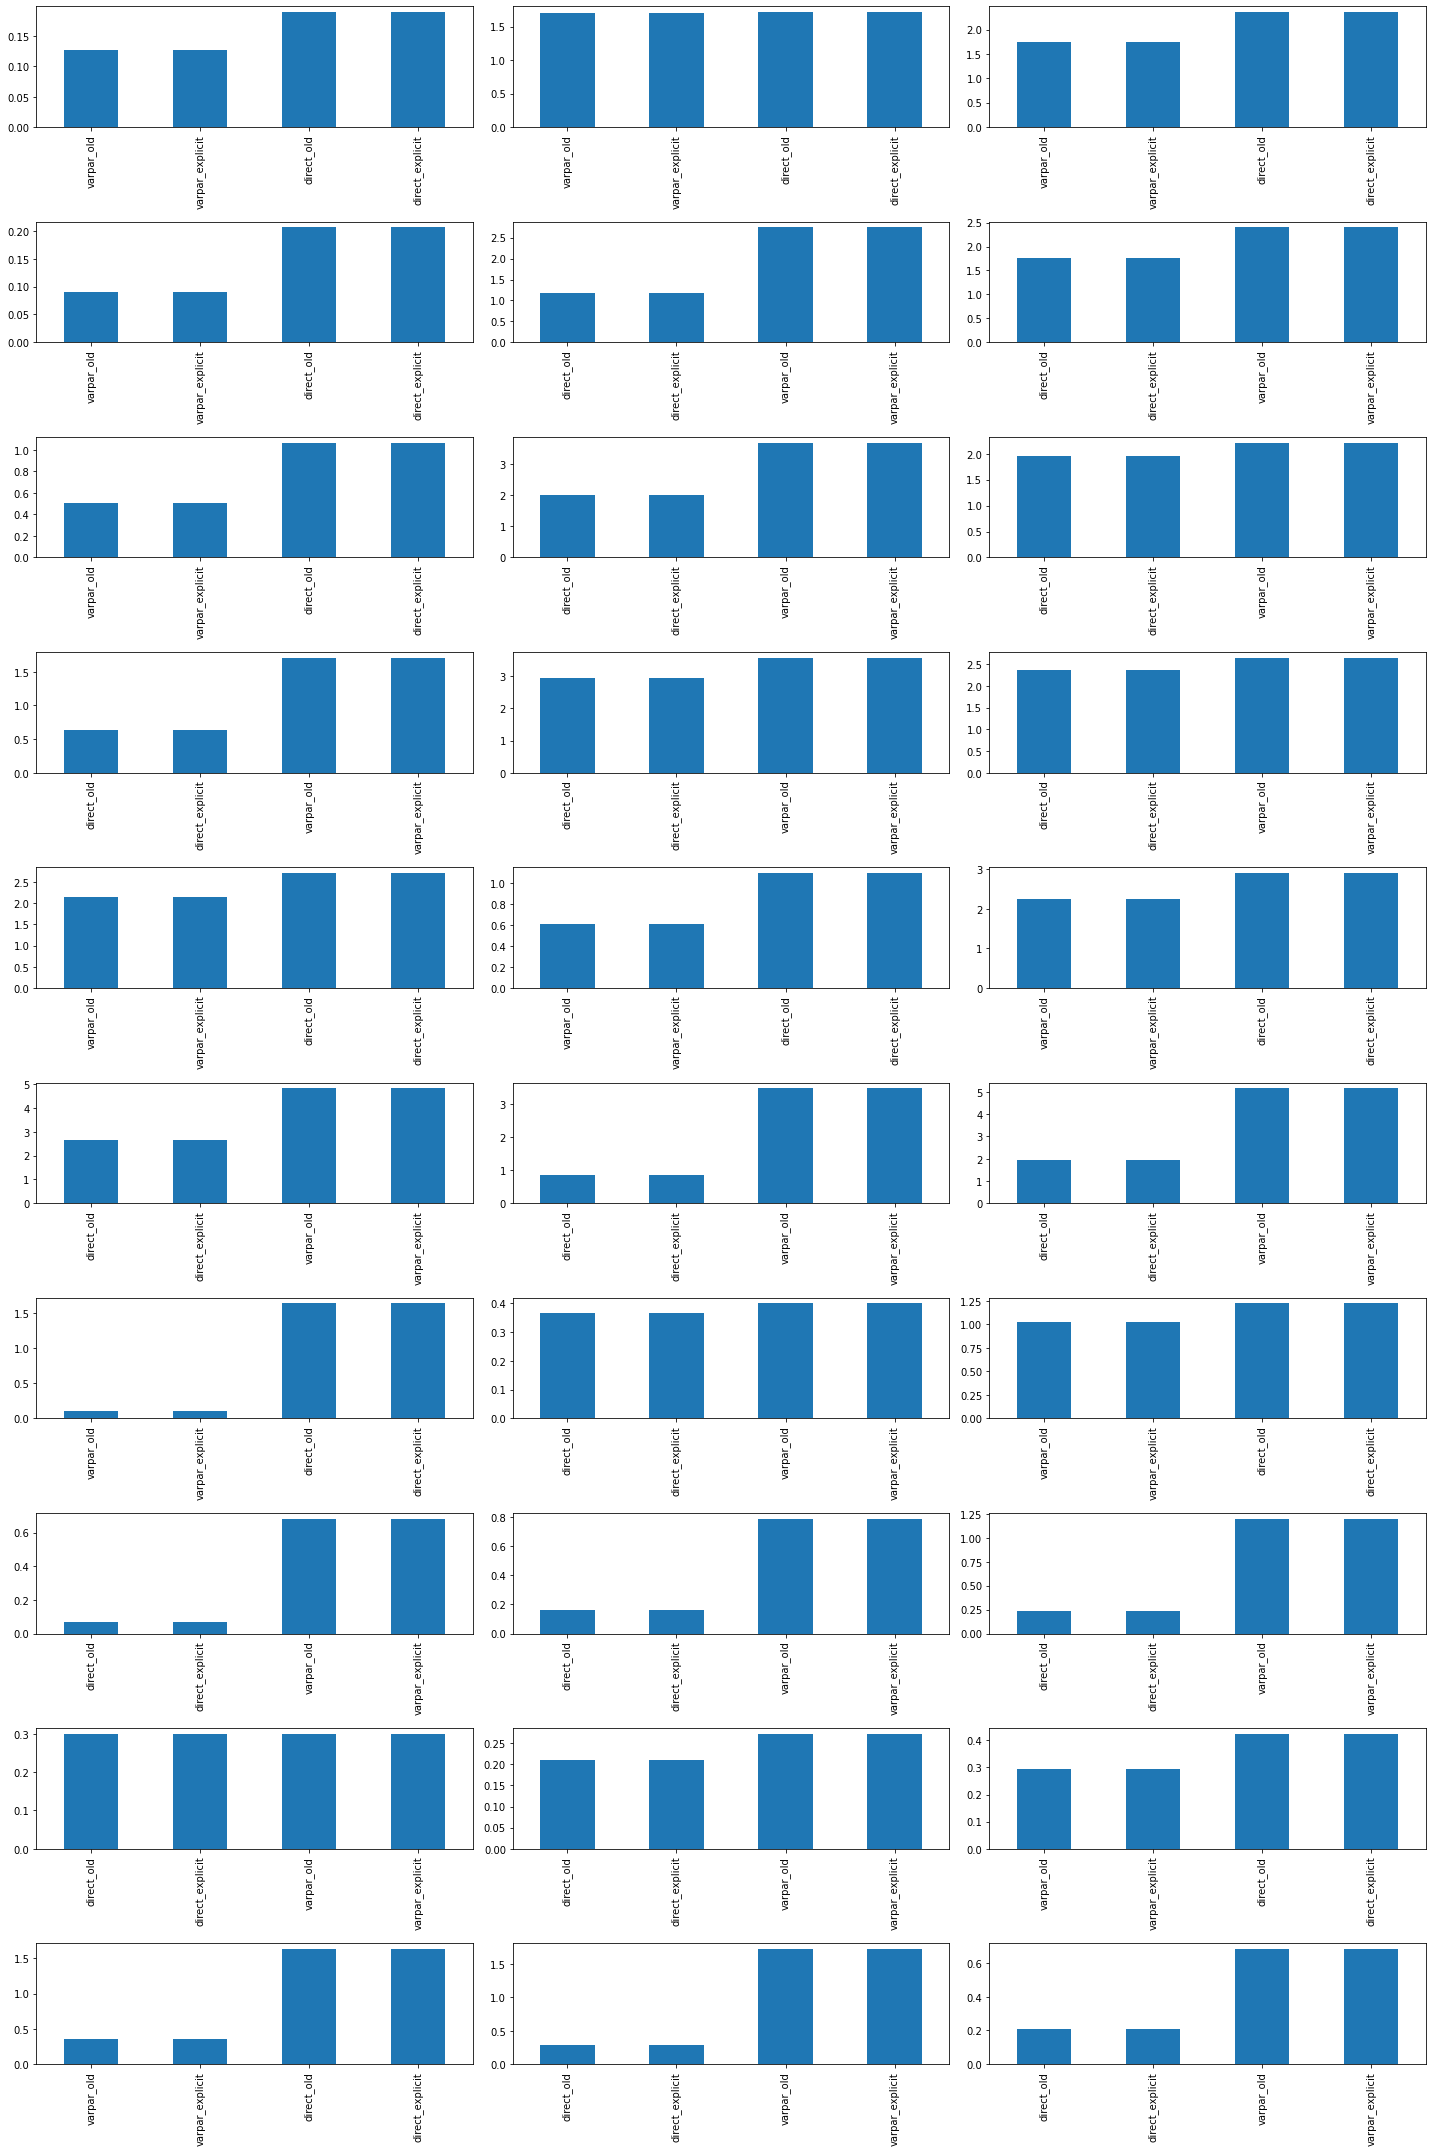

In [ ]:
fig, ax = plt.subplots(m,d,figsize=(2*m,10*d))

for i in range(m):
    for j in range(d):
        data = dataframes[i][j].iloc[0]-dataframes[i][j].iloc[-1].direct_old
        data = data.abs().sort_values()
        data.plot(kind='bar',ax=ax[i][j])
plt.tight_layout()